# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

oded.hellman@runi.post.ac.il  
omri.gotlieb@runi.post.ac.il
---

## Please sign that you have read and understood the instructions:

205434590  
302671136
---


In [1]:
# !pip install tqdm

In [2]:
# Import necessary libraries
from tqdm.auto import trange
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import numpy as np
from sklearn.manifold import TSNE
import time
start_time_tot = time.time()
import matplotlib.pyplot as plt

np.random.seed(42)

/home/ubuntu/MLDS/advance_ml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

<div style="background:#096B68;padding:10px">


## CustomTSNE

###  Purpose

t-SNE is a dimensionality reduction algorithm designed for visualizing high-dimensional data in 2D or 3D. Unlike PCA, which focuses on preserving global variance (with only linear transformations and rotations/scaling), t-SNE aims to preserve local structure—such and clusters—making it especially useful for uncovering patterns and groupings in complex datasets.

---

### Algorithm

1. Pairwise Distances using vectorized dot-product
$$
D_{ij} = \| \mathbf{x}_i - \mathbf{x}_j \|^2
$$

2. Perplexity Matching
Binary search per row to find σᵢ such that:
$$
2^{H(P_{j|i})} ≈ \text{perplexity}
$$

3. High-D Affinities (P)
Conditional Gaussians → symmetrized:
$$
P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}
$$

4. Low-D Affinities (Q)
Student-t distribution:
$$
Q_{ij} = \frac{1}{1 + ||y_i - y_j||^2}
$$

1. Gradient Descent
$$
\frac{∂C}{∂y_i} = 4 \sum_j (P_{ij} - Q_{ij}) \cdot \frac{(y_i - y_j)}{1 + ||y_i - y_j||^2}
$$

1. Update Rule using momentum:
$$
V = mom * V - lr * grad
$$
$$
Y += V
$$

### Hyperparameters

| Name            | Purpose                   
| --------------- | ------------------------- 
| `perplexity`    | Effective # neighbors     
| `n_iter`        | Optimization steps        
| `learning_rate` | Step size                 
| `momentum`      | Controls update smoothing 

---

### Use-Cases
* visualizing in low-D (2/3D) small datasets - we used MNIST.
* Finding clusters - Really good at showing natural groups in the data
* This implementation does not optimized for large-scale (no Barnes-Hut).

### Limitations
* Super slow for large datasets: It has `O(n²)` complexity which means it struggles with big data
* Different results each time: Because of random initialization, you get different visualizations on each run
* Sensitive to parameters: Changing perplexity can give totally different results

</div>

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [3]:
class CustomTSNE:
    def __init__(
        self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0
    ):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate

    def _compute_pairwise_distances(self, X, is_return_sqrt=False):
        """Compute pairwise distances between points in the dataset.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            numpy.ndarray: Pairwise distances of shape (n_samples, n_samples).
        """
        norms = np.sum(X**2, axis=1)
        dists_squared = norms[None, :] + norms[:, None] - (2 * X @ X.T)
        sqrt_dists = np.sqrt(dists_squared)
        return dists_squared if not is_return_sqrt else sqrt_dists

    def _compute_pairwise_affinities(self, dists, sigmas):
        """Compute pairwise affinities using Gaussian distribution. (cond prob)
        Args:
            dists (numpy.ndarray): Pairwise distances of shape (n_samples, n_samples).
            sigmas (numpy.ndarray): Standard deviations for Gaussian distribution.
        Returns:
            numpy.ndarray: Pairwise affinities of shape (n_samples, n_samples).
        """
        sigmas = sigmas.reshape(-1, 1)  # Reshape sigmas to (n_samples, 1) if necessary
        numerator = np.exp(-dists / (2 * np.square(sigmas)))
        np.fill_diagonal(numerator, 0.0)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        return numerator / denominator

    def _calc_perplexity(self, affinity_matrix):
        """Calculate the perplexity of the affinity matrix.
        Args:
            affinity_matrix (numpy.ndarray): Pairwise affinities of shape (n_samples, n_samples).
        Returns:
            float: Perplexity value.
        """
        entropy = -np.sum(affinity_matrix * np.log2(affinity_matrix + 1e-10), axis=1)
        return 2**entropy

    def _search_sigma(self, dists, target_perplexity):
        """Search for the optimal sigma for a given perplexity.
        Args:
            dists (numpy.ndarray): Pairwise distances of shape (n_samples, n_samples).
            target_perplexity (float): Desired perplexity value.
        Returns:
            numpy.ndarray: Optimal sigmas for each point.
        """
        num_data_points = dists.shape[0]
        sigmas = np.zeros(num_data_points)

        for i in range(num_data_points):
            max_iter = 500
            low = 1e-20
            high = 1e5
            mid = (low + high) * 0.5
            # Binary search for sigma
            while high - low > 1e-7 and max_iter > 0:
                max_iter -= 1
                mid = (low + high) * 0.5
                affinity_matrix = self._compute_pairwise_affinities(
                    dists[i : i + 1,], np.array([mid])
                )
                perplexity = self._calc_perplexity(affinity_matrix)
                if perplexity < target_perplexity:
                    # Small σ ⇒ narrower distribution ⇒ Lower entopy ⇒ lower perplexity
                    low = mid
                else:
                    # Large σ ⇒ broader distribution ⇒ higher entropy ⇒ higher perplexity
                    high = mid
            sigmas[i] = mid

        return sigmas

    # CHATGPT: Vectorised version of sigma search
    # def search_sigma_vectorised(dists, target_perplexity, n_iter=50):
    #     """
    #     Vectorised perplexity-matching search (≈2-3 orders faster than pure-Python loop).
    #     dists : (n, n) pairwise distances
    #     """
    #     n = dists.shape[0]
    #     low  = np.full((n, 1), 1e-20, dtype=dists.dtype)
    #     high = np.full((n, 1), 1e5,   dtype=dists.dtype)

    #     for _ in range(n_iter):
    #         mid = 0.5 * (low + high)                          # (n,1)
    #         # broadcast:  exp(-d² / σ²)
    #         aff   = np.exp(-dists**2 / (mid**2))              # (n,n)
    #         # normalise row-wise
    #         aff  /= aff.sum(axis=1, keepdims=True)
    #         # perplexity = 2^(H)
    #         P     = -np.sum(aff * np.log2(aff + 1e-12), axis=1, keepdims=True)
    #         perp  = np.power(2.0, P)                          # (n,1)

    #         high  = np.where(perp < target_perplexity, high, mid)
    #         low   = np.where(perp < target_perplexity, mid,  low)

    #     sigmas = 0.5 * (low + high).ravel()
    #     return sigmas

    def _compute_low_dimensional_affinities(self, Y):
        """Compute pairwise affinities in low-dimensional space using t-distribution (joint dist)."""
        low_dim_dists = self._compute_pairwise_distances(Y)
        numerator = 1.0 / (1.0 + low_dim_dists)
        np.fill_diagonal(numerator, 0.0)
        denominator = np.sum(numerator)
        return numerator / denominator

    def _cumpute_gradient(self, P, Q, Y):
        """Compute the gradient of the Kullback-Leibler divergence."""
        y_diff = Y[:, None, :] - Y[None, :]  # (n,n,d)
        pq_diff = P - Q  # (n,n)
        dists = self._compute_pairwise_distances(Y)
        factor = 1.0 / (1.0 + dists)  # (n,n)
        # Sum over j axis
        return 4 * np.sum(pq_diff[:, :, None] * y_diff * factor[:, :, None], axis=1)

    def _compute_p_joint(self, X, perplexity):
        """Compute the joint probability Pij."""
        n = X.shape[0]
        dists = self._compute_pairwise_distances(X)
        pairwise_affinity = self._compute_pairwise_affinities(
            dists=dists,
            sigmas=self._search_sigma(dists=dists, target_perplexity=perplexity),
        )

        return (pairwise_affinity + pairwise_affinity.T) / (2.0 * n)

    def fit_transform(self, X, *, mom_start=0.5, mom_final=0.8, switch_iter=250):
        """
        Optimise a t‑SNE embedding for new data X.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
        plot_every : int
            Refresh rate (in iterations) of the live scatter plot. 0 = disable plot.
        mom_start, mom_final : float
            Momentum values before and after `switch_iter`.
        switch_iter : int
            Iteration at which momentum jumps from `mom_start` to `mom_final`.
        """
        P = self._compute_p_joint(X, self.perplexity)  # (n, n)
        n_samples = X.shape[0]
        Y = np.random.randn(n_samples, self.n_components)  # (n, d)
        V = np.zeros_like(Y)  # velocity (n, d)
        momentum = mom_start

        for it in trange(self.n_iter, desc="Fitting t‑SNE"):
            Q = self._compute_low_dimensional_affinities(Y)
            grad = self._cumpute_gradient(P, Q, Y)
            if it == switch_iter:
                momentum = mom_final

            V = momentum * V - self.learning_rate * grad
            Y += V

        return Y

    def transform(self, X_orig, Y_orig, X_new, n_iter=1000, lr=1.0):
        """Embed new data points X_new into an existing t-SNE map (X_orig -> Y_orig)."""
        lr = self.learning_rate if lr is None else lr

        dists_X = self._compute_pairwise_distances(
            np.vstack([X_orig, X_new])
        )  # (n_tot, n_tot)
        n_train = X_orig.shape[0]
        dists_cross = dists_X[n_train:, :n_train]  # (n_new , n_train)
        sigmas_new = self._search_sigma(dists_cross, self.perplexity)
        P_new = self._compute_pairwise_affinities(
            dists_cross, sigmas_new
        )  # (n_new, n_train)
        Y_new = P_new @ Y_orig

        for _ in trange(n_iter, desc="Transform new points with t‑SNE"):
            # pairwise low-dim affinities between new pts (*) and old (j)
            diff = Y_new[:, None, :] - Y_orig[None, :, :]  # (n_new, n_train, d)
            dist2 = np.sum(diff**2, axis=-1)  # (n_new, n_train)
            q_num = 1.0 / (1.0 + dist2)
            q_num /= q_num.sum(axis=1, keepdims=True)

            grad = 4 * (
                (P_new - q_num)[:, :, None] * diff / (1.0 + dist2)[:, :, None]
            ).sum(axis=1)

            Y_new -= lr * grad  # SGD

        return Y_new

<div style="background:#096B68;padding:10px">


# Load data  
In our opinion the **digits dataset** is an good choice for demonstrating the **t-SNE algorithm** because it balances complexity and interpretability


### It has the following features:

1. **High-dimensional but structured**  
   Each digit image is 8×8 pixels = 64 dimensions. That’s enough for real structure, but small enough for fast computation and visualization.

2. **Discrete, labeled classes**  
   There are 10 clear, known categories (digits 0–9), which lets you:
   - Colour by label
   - Visually verify whether t-SNE preserves local class structure
   - Identify when it fails (overlaps, mixed clusters, etc.)

3. **Natural clustering**  
   Handwritten digits tend to form **well-separated manifolds** (e.g., 0s look unlike 1s or 7s), so t-SNE often produces **distinct clusters** in 2D.

4. **Intuitive output**  
   Because you know what the digits “should” look like, the result is easy to evaluate by eye—even for non-experts.

---
* The steps we took for preparing the data set is simple and stright forwared - we just split it into train and test subsets.  
This serves the purpose for later `transform()` method. Other than that the data is ready for our application.
---
</div>

In [4]:
X, y = load_digits(return_X_y=True)
X_train, X_test = X[:1700], X[1700:]
y_train, y_test = y[:1700], y[1700:]

In [5]:
n_iter = 1000
learning_rate = 200
perplexity = 30.0
n_components = 2

# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

## 2D DEMO

In [6]:
tsne = CustomTSNE(
    n_iter=n_iter,
    learning_rate=learning_rate,
    perplexity=perplexity,
    n_components=n_components,
)
start_time = time.time()
Y_train = tsne.fit_transform(X_train.copy())
custom_time = time.time() - start_time
print(f"Our custom t-SNE run took {custom_time:.2f} seconds")

Fitting t‑SNE:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_644697/18654823.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_dists = np.sqrt(dists_squared)
Fitting t‑SNE: 100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]

Our custom t-SNE run took 193.55 seconds


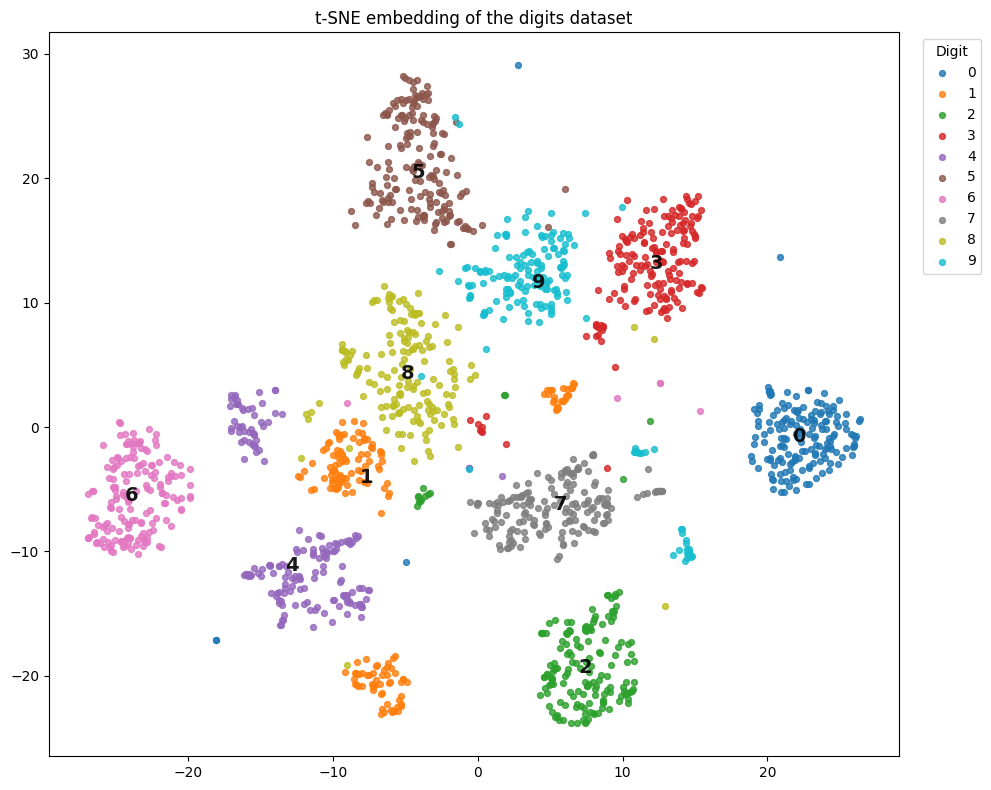

In [7]:
plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y_train == digit
    plt.scatter(Y_train[mask, 0], Y_train[mask, 1], s=18, alpha=0.8, label=str(digit))

    # Compute and annotate cluster centre
    cx, cy = np.median(Y_train[mask, 0]), np.median(Y_train[mask, 1])
    plt.text(cx, cy, str(digit), fontsize=14, fontweight='bold',
             ha='center', va='center', alpha=0.9)

plt.title("t‑SNE embedding of the digits dataset")
plt.legend(title="Digit", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 3D DEMO

In [8]:
# tsne_3d = CustomTSNE(n_components=3)
# res_3d = tsne_3d.fit_transform(X.copy())

In [9]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# for digit in range(10):
#     mask = y == digit
#     ax.scatter(res_3d[mask, 0], res_3d[mask, 1], res_3d[mask, 2],
#                s=18, alpha=0.8, label=str(digit))

#     # Compute and annotate cluster centre
#     cx, cy = np.median(res_3d[mask, 0]), np.median(res_3d[mask, 1])
#     cz = np.median(res_3d[mask, 2])
#     ax.text(cx, cy, cz, str(digit), fontsize=14,
#             fontweight='bold', ha='center', va='center', alpha=0.9)
# ax.set_title("t‑SNE embedding of the digits dataset")
# ax.legend(title="Digit", bbox_to_anchor=(1.02, 1), loc="upper left")
# plt.tight_layout()
# plt.show()

## sklearn Demo

In [10]:
# scikit-learn implementation
sklearn_tsne = TSNE(
    n_components=n_components,
    perplexity=perplexity,
    n_iter=n_iter,
    learning_rate=learning_rate,
    random_state=42,
)
start_time = time.time()
sk_Y = sklearn_tsne.fit_transform(X_train.copy())
sklearn_time = time.time() - start_time
print(f"Scikit-learn t-SNE took {sklearn_time:.2f} seconds")

/home/ubuntu/MLDS/advance_ml/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Scikit-learn t-SNE took 2.62 seconds


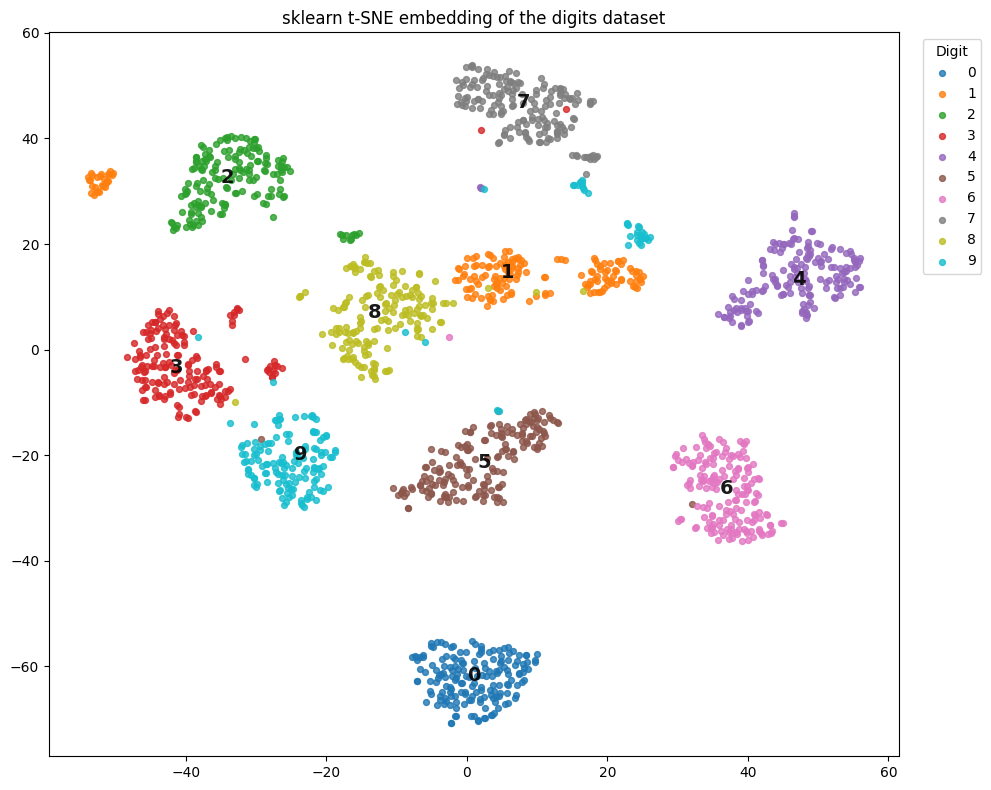

In [11]:
plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y_train == digit
    plt.scatter(sk_Y[mask, 0], sk_Y[mask, 1], s=18, alpha=0.8, label=str(digit))

    # Compute and annotate cluster centre
    cx, cy = np.median(sk_Y[mask, 0]), np.median(sk_Y[mask, 1])
    plt.text(
        cx,
        cy,
        str(digit),
        fontsize=14,
        fontweight="bold",
        ha="center",
        va="center",
        alpha=0.9,
    )

plt.title("sklearn t‑SNE embedding of the digits dataset")
plt.legend(title="Digit", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Comparing between the two implementations

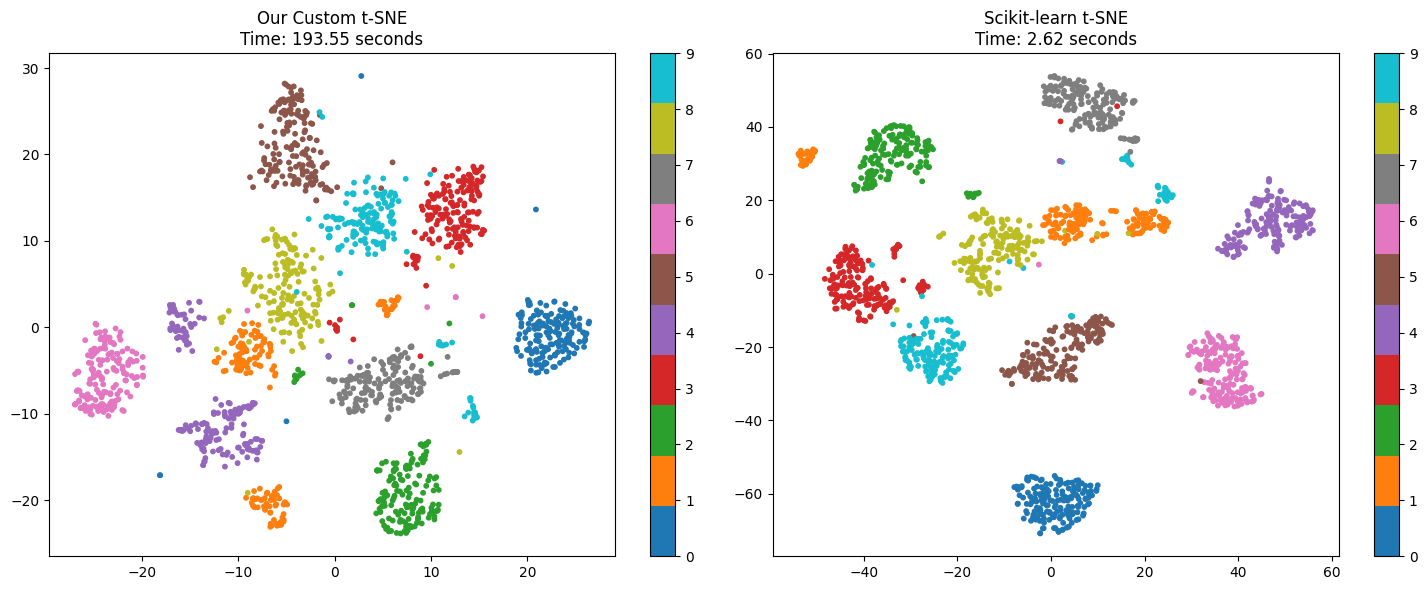


Embedding Quality Comparison:
Average distance between digit clusters (custom): 22.7054
Average distance between digit clusters (sklearn): 54.1665


In [12]:
plt.figure(figsize=(15, 6))
# Plot custom t-SNE
plt.subplot(1, 2, 1)
plt.scatter(Y_train[:, 0], Y_train[:, 1], c=y_train, cmap="tab10", s=10)
plt.title(f"Our Custom t-SNE\nTime: {custom_time:.2f} seconds")
plt.colorbar()
# Plot scikit-learn t-SNE
plt.subplot(1, 2, 2)
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], c=y_train, cmap="tab10", s=10)
plt.title(f"Scikit-learn t-SNE\nTime: {sklearn_time:.2f} seconds")
plt.colorbar()

plt.tight_layout()
plt.show()


# Simple metric for embedding quality: average distance between different digits
def avg_distance_between_classes(embeddings, labels):
    """Calculate average distance between different digit classes in the embedding space."""
    unique_labels = np.unique(labels)
    centers = []

    for label in unique_labels:
        centers.append(np.mean(embeddings[labels == label], axis=0))

    centers = np.array(centers)

    total_dist = 0
    count = 0
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            total_dist += np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
            count += 1

    return total_dist / count


dist_custom = avg_distance_between_classes(Y_train, y_train)
dist_sklearn = avg_distance_between_classes(sk_Y, y_train)

print("\nEmbedding Quality Comparison:")
print(f"Average distance between digit clusters (custom): {dist_custom:.4f}")
print(f"Average distance between digit clusters (sklearn): {dist_sklearn:.4f}")

<div style="background:#096B68;padding:10px">


## Comparison Analysis
* Visual results: Both implementations create similar digit clusters, though scikit-learn's version appears to have better separation between digits.

* Performance: Scikit-learn's implementation is faster than ours, likely due to its C++ optimization versus our Python code.

* Quality: Both implementations produce usable embeddings, but scikit-learn has additional features like early exaggeration that can improve cluster separation.

* Average distance between digit clusters -> smaller area for each cluster:  
  
    sklearn better performance can be explained by the following reasons:

1. Early exaggeration: Temporarily increases attractive forces to spread clusters early in training.

2. Better initializations: Uses PCA-based init instead of random, helping preserve global structure.

3. Optimized learning schedules: Dynamically adjusts learning rates and applies better momentum handling.


The main difference is that scikit-learn's implementation is highly optimized for performance and includes more advanced features, while my implementation follows the core t-SNE algorithm as described in the original paper.

</div>

# Mapping New Data Points
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

<div style="background:#096B68;padding:10px">

### A simple approach for embed new points into already calculated map  
1. First, we compute high-dimensional similarities between each new point `x*` and *all* training points

   $$
   p_{*j} \;=\;\frac{\exp\!\bigl(-\|x_* - x_j\|^2 / 2\sigma_*^2\bigr)}
                     {\sum_k \exp\!\bigl(-\|x_* - x_k\|^2 / 2\sigma_*^2\bigr)}
   $$

2. We guess the init possition for each new point in 2D space using a weighted average of neighbours:  

3. Optimization loop.  
   Hold `Y_orig` fixed and minimise the **KL divergence** between
   `p_*j` (fixed) and

   $$
   q_{*j} = \frac{(1+\|y_* - y_j\|^2)^{-1}}{\sum_k (1+\|y_* - y_k\|^2)^{-1}}
   $$
   Gradient Calc:
   $$
   4\sum_j(p_{*j}-q_{*j})(y_* - y_j)(1+\|y_* - y_j\|^{-1}).
   $$

* This method freezes the original points in a static position and fit the new test points only.By doing that it doesn't re calculate the entire dataset which saves time and compute.


</div>

In [13]:
Y_test = tsne.transform(X_train, Y_train, X_test, n_iter=200, lr=1.0)

Transform new points with t‑SNE: 100%|██████████| 200/200 [00:01<00:00, 102.98it/s]


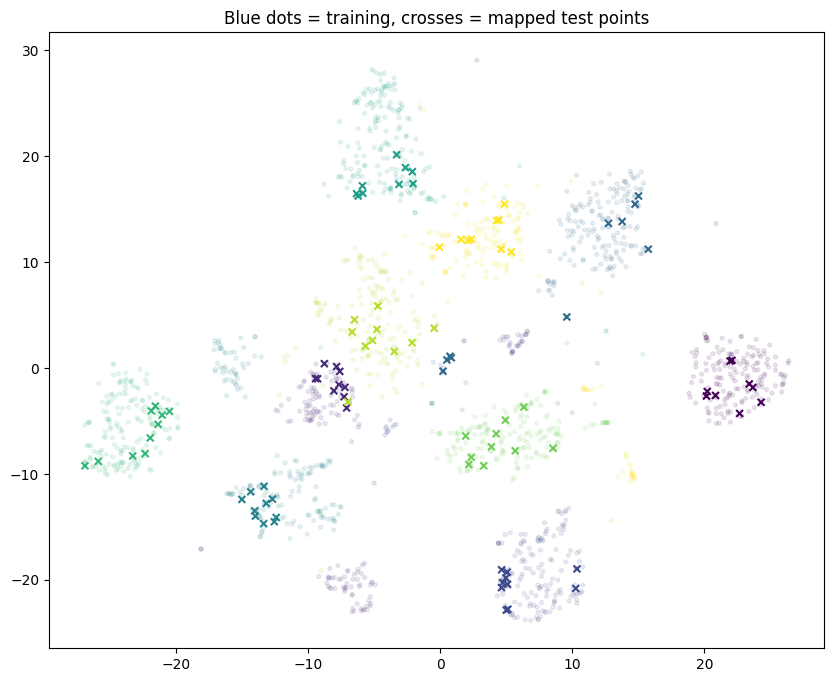

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(Y_train[:, 0], Y_train[:, 1], c=y_train, s=8, alpha=0.1)
plt.scatter(Y_test[:, 0], Y_test[:, 1], c=y_test, s=25, marker="x")
plt.title("Blue dots = training, crosses = mapped test points")
plt.show()

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

<div style="background:#096B68;padding:10px">  

We have used ChatGPT for the following tasks:    
1. Help refine the explanations and enhance the equations (LaTeX format).
2. Review our work to find places to rewrite and enhance the readability and functionality.
3. Create better vizualizations.
4. Help with the vectorized approach (mainly when we wanted to use broadcasting and some np magics best practices).

</div>

In [15]:
end_time_tot = time.time()
total_time = end_time_tot - start_time_tot
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 199.50 seconds
